# Phase 4 — Bayesian Hyperparameter Tuning (Optuna)
**Inputs:** `X_train_fe.csv`, `y_train_fe.csv` (Phase 2) · `X_test_fe` rebuilt from Phase 1 outputs  
**Objective:** Maximise PR-AUC on temporal validation set  
**Constraint:** No test-set touch until final evaluation · No SMOTE · No random split

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ── Load engineered training data (Phase 2 outputs) ───────────────────────────
X_train_fe = pd.read_csv("data/processed/X_train_fe.csv")
y_train_fe = pd.read_csv("data/processed/y_train_fe.csv")

# ── Load raw test data + scaling params to rebuild X_test_fe (no leakage) ────
X_test_raw     = pd.read_csv("data/processed/X_test.csv")
y_test_raw     = pd.read_csv("data/processed/y_test.csv")
scaling_params = pd.read_csv("data/processed/train_scaling_params.csv").iloc[0]
MEAN_AMOUNT    = scaling_params["mean_amount"]
STD_AMOUNT     = scaling_params["std_amount"]

# Re-use the same leakage-safe pipeline from Phase 3
def apply_feature_pipeline(df_raw, y_raw, mean_amount, std_amount,
                            window_amount=100, window_fraud=500):
    df = df_raw.copy()
    df["Class"] = y_raw["Class"].values
    df = df.sort_values("Time").reset_index(drop=True)
    df["log_amount"]           = np.log1p(df["Amount"])
    df["amount_zscore_global"] = (df["Amount"] - mean_amount) / std_amount
    amt_shifted = df["Amount"].shift(1)
    df["rolling_mean_amount"]  = amt_shifted.rolling(window_amount, min_periods=1).mean()
    df["rolling_std_amount"]   = amt_shifted.rolling(window_amount, min_periods=2).std(ddof=1)
    df["time_diff"]            = df["Time"] - df["Time"].shift(1)
    df["amount_deviation"]     = df["Amount"] - df["rolling_mean_amount"]
    std_safe                   = df["rolling_std_amount"].replace(0, np.nan)
    df["amount_zscore_rolling"] = df["amount_deviation"] / std_safe
    cls_shifted = df["Class"].shift(1)
    df["rolling_fraud_count_500"] = cls_shifted.rolling(window_fraud, min_periods=1).sum()
    df["rolling_fraud_rate_500"]  = cls_shifted.rolling(window_fraud, min_periods=1).mean()
    ENGINEERED = ["log_amount","amount_zscore_global","rolling_mean_amount",
                  "rolling_std_amount","time_diff","amount_deviation",
                  "amount_zscore_rolling","rolling_fraud_count_500","rolling_fraud_rate_500"]
    all_cols   = list(df_raw.columns) + ENGINEERED
    out        = df[all_cols + ["Class"]].dropna().reset_index(drop=True)
    return out[all_cols], out[["Class"]]

X_test_fe, y_test_fe = apply_feature_pipeline(X_test_raw, y_test_raw, MEAN_AMOUNT, STD_AMOUNT)
FEATURE_COLS = list(X_train_fe.columns)
X_test_fe    = X_test_fe[FEATURE_COLS]

y_tr = y_train_fe["Class"].values
y_te = y_test_fe["Class"].values

print(f"X_train_fe : {X_train_fe.shape}  fraud={y_tr.mean()*100:.4f}%")
print(f"X_test_fe  : {X_test_fe.shape}   fraud={y_te.mean()*100:.4f}%")

X_train_fe : (227843, 39)  fraud=0.1830%
X_test_fe  : (56960, 39)   fraud=0.1317%


## Step 1 — Temporal Validation Split

Last 20% of the time-ordered training set becomes the validation set for Optuna.  
The test set is **never seen** during search — it is held out until Step 3.

In [2]:
# ── Temporal 80/20 split of training data (no shuffle, mirrors Phase 1 logic) ─
val_cutoff = int(len(X_train_fe) * 0.80)

X_tr  = X_train_fe.iloc[:val_cutoff].reset_index(drop=True)
y_tr_ = y_tr[:val_cutoff]
X_val = X_train_fe.iloc[val_cutoff:].reset_index(drop=True)
y_val = y_tr[val_cutoff:]

# Global class-imbalance ratio for scale_pos_weight upper bound
n_neg_full = (y_tr == 0).sum()
n_pos_full = (y_tr == 1).sum()
SPW_MAX    = n_neg_full / n_pos_full

print(f"Optuna train subset : {X_tr.shape}   fraud={y_tr_.mean()*100:.4f}%")
print(f"Optuna val  subset  : {X_val.shape}   fraud={y_val.mean()*100:.4f}%")
print(f"scale_pos_weight max (neg/pos) = {SPW_MAX:.1f}")

Optuna train subset : (182274, 39)   fraud=0.2002%
Optuna val  subset  : (45569, 39)   fraud=0.1141%
scale_pos_weight max (neg/pos) = 545.4


## Step 2 — Optuna Bayesian Search

**Sampler:** `TPESampler` (Tree-structured Parzen Estimator) — Optuna's default Bayesian method.  
**Pruner:** `MedianPruner` — kills unpromising trials early based on intermediate PR-AUC checkpoints, saving time.  
**Objective:** maximise PR-AUC on the temporal validation set.  
The test set is **never touched** during search.

In [3]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners  import MedianPruner
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score

optuna.logging.set_verbosity(optuna.logging.WARNING)   # suppress per-trial noise

N_TRIALS = 75   # increase to 100 for a longer, more thorough search

def objective(trial: optuna.Trial) -> float:
    params = dict(
        objective          = "binary:logistic",
        eval_metric        = "aucpr",
        verbosity          = 0,
        n_jobs             = -1,
        random_state       = 42,
        # ── Tuned hyperparameters ─────────────────────────────────────────
        max_depth          = trial.suggest_int  ("max_depth",         3,   10),
        learning_rate      = trial.suggest_float("learning_rate",     0.01, 0.2,  log=True),
        n_estimators       = trial.suggest_int  ("n_estimators",      200, 1000),
        min_child_weight   = trial.suggest_int  ("min_child_weight",  1,   10),
        subsample          = trial.suggest_float("subsample",         0.5,  1.0),
        colsample_bytree   = trial.suggest_float("colsample_bytree",  0.5,  1.0),
        scale_pos_weight   = trial.suggest_float("scale_pos_weight",  1.0,  SPW_MAX),
        # ── Additional regularisation in search space ─────────────────────
        gamma              = trial.suggest_float("gamma",             0.0,  5.0),
        reg_alpha          = trial.suggest_float("reg_alpha",         0.0,  2.0),
        reg_lambda         = trial.suggest_float("reg_lambda",        0.5,  5.0),
    )

    model = XGBClassifier(
        **params,
        early_stopping_rounds=40,
    )
    model.fit(
        X_tr, y_tr_,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )

    val_proba = model.predict_proba(X_val)[:, 1]
    pr_auc    = average_precision_score(y_val, val_proba)
    return pr_auc


# ── Run the study ─────────────────────────────────────────────────────────────
study = optuna.create_study(
    direction = "maximize",
    sampler   = TPESampler(seed=42),
    pruner    = MedianPruner(n_startup_trials=10, n_warmup_steps=5),
    study_name= "xgb_fraud_prauc",
)

print(f"Running {N_TRIALS} Optuna trials … (this may take a few minutes)")
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

best = study.best_trial
print(f"\nBest trial:  #{best.number}")
print(f"  PR-AUC (val) = {best.value:.6f}")
print(f"\nBest hyperparameters:")
for k, v in best.params.items():
    print(f"  {k:<22s} = {v}")

Running 75 Optuna trials … (this may take a few minutes)


Best trial: 56. Best value: 0.799074: 100%|██████████| 75/75 [01:15<00:00,  1.00s/it]


Best trial:  #56
  PR-AUC (val) = 0.799074

Best hyperparameters:
  max_depth              = 10
  learning_rate          = 0.06780859048500378
  n_estimators           = 630
  min_child_weight       = 6
  subsample              = 0.7001414585714342
  colsample_bytree       = 0.6028408273401912
  scale_pos_weight       = 323.85842780882183
  gamma                  = 3.2144590342622803
  reg_alpha              = 1.901921747325168
  reg_lambda             = 0.5531710927645284


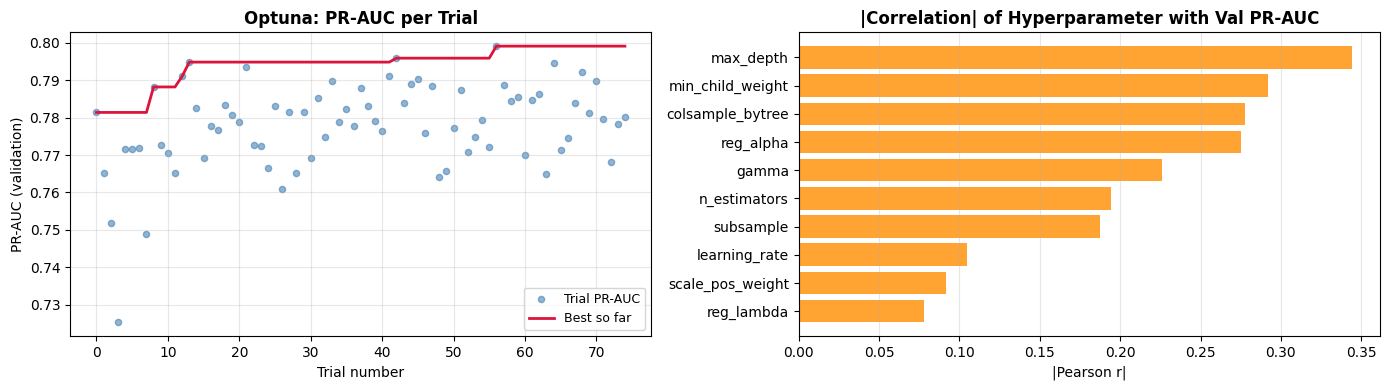

Saved: data/processed/optuna_history.png


In [4]:
import os

# ── Optuna optimisation history ───────────────────────────────────────────────
trial_nums  = [t.number for t in study.trials if t.value is not None]
trial_vals  = [t.value  for t in study.trials if t.value is not None]
running_max = pd.Series(trial_vals).cummax().tolist()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].scatter(trial_nums, trial_vals, s=20, alpha=0.6, color="steelblue", label="Trial PR-AUC")
axes[0].plot(trial_nums, running_max, color="crimson", lw=2, label="Best so far")
axes[0].set_title("Optuna: PR-AUC per Trial", fontweight="bold")
axes[0].set_xlabel("Trial number")
axes[0].set_ylabel("PR-AUC (validation)")
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

# ── Hyperparameter importance (manual: correlation of each param with PR-AUC) ─
param_names = list(best.params.keys())
importances = []
for p in param_names:
    vals = [t.params.get(p, np.nan) for t in study.trials if t.value is not None]
    aucs = [t.value for t in study.trials if t.value is not None]
    if len(set(vals)) > 1:
        importances.append(abs(np.corrcoef(vals, aucs)[0, 1]))
    else:
        importances.append(0.0)

imp_s = pd.Series(importances, index=param_names).sort_values(ascending=True)
axes[1].barh(imp_s.index, imp_s.values, color="darkorange", alpha=0.8)
axes[1].set_title("|Correlation| of Hyperparameter with Val PR-AUC", fontweight="bold")
axes[1].set_xlabel("|Pearson r|")
axes[1].grid(axis="x", alpha=0.3)

plt.tight_layout()
os.makedirs("data/processed", exist_ok=True)
plt.savefig("data/processed/optuna_history.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: data/processed/optuna_history.png")

## Step 3 — Retrain Best Model on Full Training Set

The winning hyperparameters are applied to the **complete** `X_train_fe` (train + the validation slice used by Optuna).  
Early stopping is disabled for the final refit — we use the best `n_estimators` found.

In [5]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_fscore_support, confusion_matrix,
    roc_curve, precision_recall_curve,
)

# ── Build final model with best params, no early stopping ────────────────────
best_params = best.params.copy()

xgb_tuned = XGBClassifier(
    objective        = "binary:logistic",
    eval_metric      = "aucpr",
    verbosity        = 0,
    n_jobs           = -1,
    random_state     = 42,
    **best_params,
)

print("Retraining on full X_train_fe with best params …")
xgb_tuned.fit(X_train_fe, y_tr)
print("Done.")

# ── Evaluate on test set (first time test set is touched this phase) ──────────
tuned_proba = xgb_tuned.predict_proba(X_test_fe)[:, 1]
tuned_pred  = (tuned_proba >= 0.5).astype(int)

tuned_roc_auc = roc_auc_score(y_te, tuned_proba)
tuned_pr_auc  = average_precision_score(y_te, tuned_proba)
prec_t, rec_t, f1_t, _ = precision_recall_fscore_support(
    y_te, tuned_pred, pos_label=1, average="binary"
)
cm_t = confusion_matrix(y_te, tuned_pred)
tn_t, fp_t, fn_t, tp_t = cm_t.ravel()

print(f"\nXGBoost Tuned — Test Set Metrics")
print(f"{'─'*40}")
print(f"  ROC-AUC   : {tuned_roc_auc:.4f}")
print(f"  PR-AUC    : {tuned_pr_auc:.4f}")
print(f"  Recall    : {rec_t:.4f}")
print(f"  Precision : {prec_t:.4f}")
print(f"  F1-score  : {f1_t:.4f}")
print(f"\n  Confusion Matrix:")
print(f"  TN={tn_t:,}  FP={fp_t:,}")
print(f"  FN={fn_t:,}  TP={tp_t:,}")


# ── Helper: Recall @ target FPR ──────────────────────────────────────────────
def recall_at_fpr(y_true, y_proba, target_fpr=0.01):
    fpr_arr, tpr_arr, thresh_arr = roc_curve(y_true, y_proba)
    idx = max(0, min(np.searchsorted(fpr_arr, target_fpr, side="right") - 1,
                     len(thresh_arr) - 1))
    threshold  = thresh_arr[idx]
    recall_val = tpr_arr[idx]
    actual_fpr = fpr_arr[idx]
    prec_arr, rec_arr, _ = precision_recall_curve(y_true, y_proba)
    prec_val = prec_arr[np.argmin(np.abs(rec_arr - recall_val))]
    return recall_val, prec_val, threshold, actual_fpr

TARGET_FPR = 0.01
tuned_rec_fpr, tuned_prec_fpr, tuned_thresh, tuned_actual_fpr = recall_at_fpr(y_te, tuned_proba)

print(f"\n  Recall @ {TARGET_FPR*100:.0f}% FPR : {tuned_rec_fpr:.4f}  "
      f"(precision={tuned_prec_fpr:.4f}, threshold={tuned_thresh:.4f})")


# ── Cost evaluation ───────────────────────────────────────────────────────────
FRAUD_LOSS = 200
FP_COST    = 5

def compute_cost(y_true, y_pred):
    tn_, fp_, fn_, tp_ = confusion_matrix(y_true, y_pred).ravel()
    return (fn_ * FRAUD_LOSS) + (fp_ * FP_COST), fn_, fp_

# Optimal threshold sweep on test set
thresholds  = np.linspace(0.01, 0.99, 300)
tuned_costs = [compute_cost(y_te, (tuned_proba >= t).astype(int))[0] for t in thresholds]
tuned_opt_t = thresholds[np.argmin(tuned_costs)]
tuned_opt_cost, *_ = compute_cost(y_te, (tuned_proba >= tuned_opt_t).astype(int))
tuned_cost_default, *_ = compute_cost(y_te, tuned_pred)

print(f"\n  Cost @ t=0.5       : €{tuned_cost_default:,.0f}")
print(f"  Cost @ t={tuned_opt_t:.2f} (opt): €{tuned_opt_cost:,.0f}")

Retraining on full X_train_fe with best params …
Done.

XGBoost Tuned — Test Set Metrics
────────────────────────────────────────
  ROC-AUC   : 0.9877
  PR-AUC    : 0.7966
  Recall    : 0.7600
  Precision : 0.8507
  F1-score  : 0.8028

  Confusion Matrix:
  TN=56,875  FP=10
  FN=18  TP=57

  Recall @ 1% FPR : 0.8800  (precision=0.0935, threshold=0.0028)

  Cost @ t=0.5       : €3,650
  Cost @ t=0.13 (opt): €3,130


## Step 4 — Three-Way Comparison

Logistic Regression and XGBoost baseline metrics are loaded from Phase 3 results.  
XGBoost Tuned metrics are from the retrained model above.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ── Rebuild LR baseline (Phase 3 parameters, identical) ─────────────────────
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(class_weight="balanced", max_iter=1000,
                              random_state=42, solver="lbfgs", n_jobs=-1))
])
lr_pipeline.fit(X_train_fe, y_tr)
lr_proba = lr_pipeline.predict_proba(X_test_fe)[:, 1]
lr_pred  = lr_pipeline.predict(X_test_fe)

# ── Rebuild XGB baseline (Phase 3 fixed params) ───────────────────────────────
n_neg_b   = (y_tr == 0).sum()
n_pos_b   = (y_tr == 1).sum()
xgb_base  = XGBClassifier(
    objective="binary:logistic", eval_metric="aucpr",
    scale_pos_weight=n_neg_b/n_pos_b,
    max_depth=6, learning_rate=0.05, n_estimators=500,
    early_stopping_rounds=50, subsample=0.8, colsample_bytree=0.8,
    random_state=42, n_jobs=-1, verbosity=0,
)
xgb_base.fit(X_tr, y_tr_,
             eval_set=[(X_val, y_val)], verbose=False)
xgb_proba = xgb_base.predict_proba(X_test_fe)[:, 1]
xgb_pred  = (xgb_proba >= 0.5).astype(int)

# ── Helper: all metrics for one model ────────────────────────────────────────
def all_metrics(y_true, y_proba, y_pred, label):
    roc  = roc_auc_score(y_true, y_proba)
    pr   = average_precision_score(y_true, y_proba)
    rec_fpr, prec_fpr, thr, afpr = recall_at_fpr(y_true, y_proba)
    _, _, f1_, _ = precision_recall_fscore_support(
        y_true, y_pred, pos_label=1, average="binary")
    costs = [compute_cost(y_true, (y_proba >= t).astype(int))[0] for t in thresholds]
    opt_t = thresholds[np.argmin(costs)]
    opt_c, *_ = compute_cost(y_true, (y_proba >= opt_t).astype(int))
    def_c, *_ = compute_cost(y_true, y_pred)
    return {
        "Model"              : label,
        "ROC-AUC"            : roc,
        "PR-AUC"             : pr,
        f"Recall@{TARGET_FPR*100:.0f}%FPR" : rec_fpr,
        f"Prec@{TARGET_FPR*100:.0f}%FPR"   : prec_fpr,
        "F1 (t=0.5)"         : f1_,
        "Cost € (t=0.5)"     : def_c,
        "Cost € (opt t)"     : opt_c,
        "Opt threshold"      : opt_t,
    }

rows = [
    all_metrics(y_te, lr_proba,    lr_pred,    "Logistic Regression"),
    all_metrics(y_te, xgb_proba,   xgb_pred,   "XGBoost Baseline"),
    all_metrics(y_te, tuned_proba, tuned_pred,  "XGBoost Tuned"),
]
results = pd.DataFrame(rows).set_index("Model")

# ── Print table ───────────────────────────────────────────────────────────────
fmt = {
    "ROC-AUC"                          : "{:.4f}",
    "PR-AUC"                           : "{:.4f}",
    f"Recall@{TARGET_FPR*100:.0f}%FPR" : "{:.4f}",
    f"Prec@{TARGET_FPR*100:.0f}%FPR"   : "{:.4f}",
    "F1 (t=0.5)"                       : "{:.4f}",
    "Cost € (t=0.5)"                   : "€{:,.0f}",
    "Cost € (opt t)"                   : "€{:,.0f}",
    "Opt threshold"                    : "{:.2f}",
}
display_df = results.copy()
for col, f in fmt.items():
    display_df[col] = display_df[col].map(lambda v, f=f: f.format(v))

print("=" * 90)
print(display_df.to_string())
print("=" * 90)
print(f"\nCost assumptions: FN × €{FRAUD_LOSS}  +  FP × €{FP_COST}")
print(f"Best Optuna val PR-AUC: {best.value:.6f}  (trial #{best.number}, {N_TRIALS} total trials)")

                    ROC-AUC  PR-AUC Recall@1%FPR Prec@1%FPR F1 (t=0.5) Cost € (t=0.5) Cost € (opt t) Opt threshold
Model                                                                                                             
Logistic Regression  0.9861  0.7597       0.8667     0.0893     0.1045         €7,195         €2,965          0.87
XGBoost Baseline     0.9770  0.7993       0.8667     0.0507     0.8201         €3,635         €3,205          0.14
XGBoost Tuned        0.9877  0.7966       0.8800     0.0935     0.8028         €3,650         €3,130          0.13

Cost assumptions: FN × €200  +  FP × €5
Best Optuna val PR-AUC: 0.799074  (trial #56, 75 total trials)


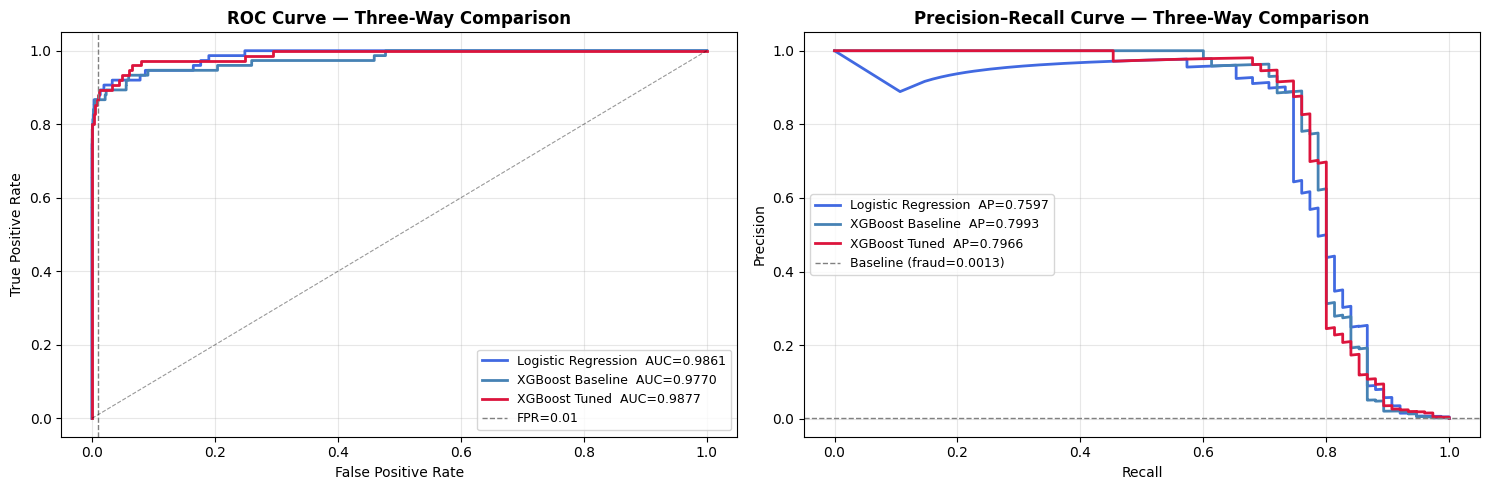

Saved: data/processed/comparison_roc_pr.png

Phase 4 complete.


In [7]:
# ── Three-way ROC + PR curve plot ────────────────────────────────────────────
models_plot = [
    ("Logistic Regression", lr_proba,    "royalblue"),
    ("XGBoost Baseline",    xgb_proba,   "steelblue"),
    ("XGBoost Tuned",       tuned_proba, "crimson"),
]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for label, proba, color in models_plot:
    fpr_, tpr_, _ = roc_curve(y_te, proba)
    auc = roc_auc_score(y_te, proba)
    axes[0].plot(fpr_, tpr_, label=f"{label}  AUC={auc:.4f}", color=color, lw=2)

axes[0].axvline(TARGET_FPR, color="gray", linestyle="--", lw=1,
                label=f"FPR={TARGET_FPR}")
axes[0].plot([0,1],[0,1], "k--", lw=0.8, alpha=0.4)
axes[0].set_title("ROC Curve — Three-Way Comparison", fontweight="bold")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

for label, proba, color in models_plot:
    p_, r_, _ = precision_recall_curve(y_te, proba)
    ap = average_precision_score(y_te, proba)
    axes[1].plot(r_, p_, label=f"{label}  AP={ap:.4f}", color=color, lw=2)

axes[1].axhline(y_te.mean(), color="gray", linestyle="--", lw=1,
                label=f"Baseline (fraud={y_te.mean():.4f})")
axes[1].set_title("Precision–Recall Curve — Three-Way Comparison", fontweight="bold")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("data/processed/comparison_roc_pr.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: data/processed/comparison_roc_pr.png")
print("\nPhase 4 complete.")